In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, plotting as pt, score as sc

2020-12-22 16:21:23,745 - NumExpr defaulting to 8 threads.


In [2]:
path = '../raw_data/'

In [3]:
at_raw = pd.read_csv(path+'active_totes_20201210.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-0912.csv',names = ["timestamp","Pick Station","Availability","Blue Tote Loss","Grey Tote Loss"])
scs_raw = pd.read_csv(path + 'Faults20_11-10_12.csv')

In [4]:
# # HOTFIX - remove odd day
# at_raw = at_raw[~at_raw['DAY'].isin([9])]

In [5]:
fa = feat.add_code(scs_raw)
fa, unmapped = feat.add_tote_colour(fa)

Running: Function "load_tote_lookup" (id=2724641966832) was called 1 times


In [6]:
at = feat.pre_process_AT(at_raw)

Running: Function "pre_process_AT" (id=2724641967696) was called 1 times


In [7]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=2724641967984) was called 1 times


In [8]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=2724641966256) was called 1 times
Running: Function "load_module_lookup" (id=2724641964960) was called 1 times
Running: Function "load_ID_lookup" (id=2724641965680) was called 1 times
duplicated location faults removed - max duration kept
HOTFIX: Quadrant only faults, PTT Asset Code update


In [25]:
fa_floor = feat.floor_shift_time_fa(fa, shift=-15)

Time shifted by -15Minutes


In [26]:
mod = [1]
limit = 0

In [27]:
fa_sel_1 = feat.get_data_faults(fa_floor, modules = mod)

most_common = list(((fa_sel_1['Asset Code'].value_counts() > limit)[fa_sel_1['Asset Code'].value_counts() > limit]).index)
fa_sel = fa_sel_1[fa_sel_1['Asset Code'].isin(most_common)]

Running: Function "load_PTT_lookup" (id=2724641966544) was called 2 times


In [28]:
#fa_sel = feat.fault_select(fa_floor, fault_select_options = {'Tote Colour':['Blue']})
                                                            
fa_agg = feat.faults_aggregate(fa_sel, fault_agg_level= 'Asset Code', agg_type = 'count')

In [76]:
av_sel, at_sel = feat.av_at_select(av, at, remove_high_AT = True, availability_select_options = {"Module" : mod})

av_agg = feat.aggregate_availability(av_sel, agg_level = 'Module')
at_agg = feat.aggregate_totes(at_sel, agg_level = 'Module')

Running: Function "aggregate_availability" (id=2724641966688) was called 3 times


In [77]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, agg_level = 'None')

In [78]:
X,y = md.gen_feat_var(df)
X = X.drop('Module', axis=1)
# Flip to availability
y=1-y

In [80]:
X_train, X_test, y_train, y_test = md.split(X[['TOTES']],y)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test,
                                                              fit_intercept=False)

cv_R2 = md.cross_validate_r2(Linear_mdl, X[['TOTES']], y, n_folds = 5, shuffle = True, random_state = 101)


Cross Validation Scores LinearRegression(fit_intercept=False): 
 
        R2 Scores
1      -0.242974
2       0.281424
3      -0.134896
4       0.139777
5       0.320503
Mean    0.072767
STD     0.224596


In [83]:
df['Availability'] = 1 - df['Downtime']
#df['Log_Av'] = np.log2()

In [ ]:
l

In [87]:
df['TOTES'].mean()

43.000698931200944

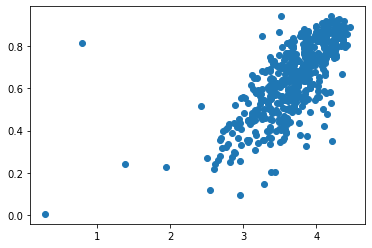

In [91]:
plt.scatter(np.log(df['TOTES']), df['Availability'])

(0.0, 1.0)

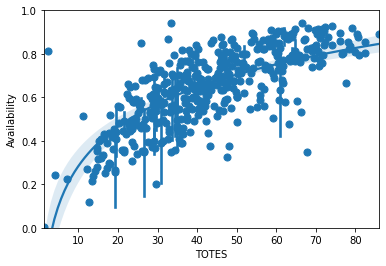

In [84]:
ax = sns.regplot(x="TOTES", y="Availability", data=df,
                 x_estimator=np.mean, logx=True)
plt.ylim(0, 1)

In [52]:
df['Availability']

,timestamp,Downtime,Blue Tote Loss,Grey Tote Loss,C05,C0501ACH011,C0501RDC004,C0501STA002,C0501STA012,C0501STA020,...,SCS011,SCS012,SCS013,SCS014,SCS015,SCS016,SCSM01,Module,TOTES,Availability
0,2020-11-19 23:00:00,0.242873,0.242873,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,32.833333,0.757127
1,2020-11-20 00:00:00,0.183683,0.183683,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,36.271186,0.816317
2,2020-11-20 01:00:00,0.132490,0.132490,0.000000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,32.550000,0.867510
3,2020-11-20 02:00:00,0.411007,0.354306,0.056701,0,0,0,0,0,0,...,2,0,0,0,0,0,0,1,23.633333,0.588993
4,2020-11-20 03:00:00,0.058651,0.058651,0.000000,0,0,0,0,1,0,...,2,0,0,0,0,0,0,1,33.533333,0.941349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,2020-12-09 13:00:00,0.172293,0.010000,0.162293,0,0,0,0,1,0,...,0,0,0,1,1,1,0,1,68.733333,0.827707
471,2020-12-09 14:00:00,0.107759,0.000000,0.107759,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,70.350000,0.892241
472,2020-12-09 15:00:00,0.130065,0.005333,0.124732,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,62.966667,0.869935
473,2020-12-09 16:00:00,0.200727,0.118905,0.081822,0,0,0,0,0,0,...,0,0,0,1,0,0,2,1,38.500000,0.799273


(0.0, 80.0)

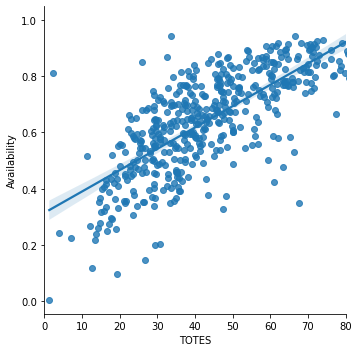

In [45]:
sns.lmplot(x='TOTES', y='Availability', data=df)
plt.xlim(0, 80)

In [33]:
X_train, X_test, y_train, y_test = md.split(X[['TOTES']],y)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test,
                                                              fit_intercept=False)

cv_R2 = md.cross_validate_r2(Linear_mdl, X[['TOTES']], y, n_folds = 5, shuffle = True, random_state = 101)


Cross Validation Scores LinearRegression(fit_intercept=False): 
 
        R2 Scores
1      -0.242974
2       0.281424
3      -0.134896
4       0.139777
5       0.320503
Mean    0.072767
STD     0.224596


In [34]:
X_train, X_test, y_train, y_test = md.split(X,y)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test,
                                                              fit_intercept=False)

cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 5, shuffle = True, random_state = 101)


Cross Validation Scores LinearRegression(fit_intercept=False): 
 
        R2 Scores
1      -1.288845
2      -0.840903
3      -1.925331
4      -2.319373
5      -0.993040
Mean   -1.473498
STD     0.562987


In [35]:
# model = sm.OLS(y_train, X_train)
# results = model.fit()
# print(results.summary())

In [36]:
X_train_rd = X_train
max_p = 1
while max_p > 0.10:
    model = sm.OLS(y_train, X_train_rd)
    results = model.fit()
    max_p = max(results.pvalues)
    rm_col = results.pvalues[results.pvalues == max_p].index.values[0]
    X_train_rd = X_train_rd.drop([rm_col], axis=1)
X_train_rd.columns

C:\Users\chris.hughes\Anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\chris.hughes\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Index(['C0501STA012', 'C0502ACH079', 'C0502STA030', 'C0502STA039',
       'C0502STA059', 'C0502STA060', 'C0502STA097', 'C0503ACH234',
       'C0503STA226', 'C05PTT012', 'C0703ACH114', 'C1501RDC224', 'C1501RDC232',
       'C1501STA213', 'C1502ACH004', 'C1502STA006', 'C1502STA034',
       'C1603BCL054', 'C1603BCL099', 'C1603RDC125', 'C1603RDC172',
       'C1603RDC173', 'C1603RDC254', 'C1603STA103', 'C1603STA253',
       'C2301ACH090', 'C2301BCL177', 'C2301RDC061', 'C2301RDC178',
       'C2301STA022', 'C2301STA085', 'C2303ACH049', 'C2303ACH218',
       'C2303BCH220', 'C2303BCL040', 'C2303BCL081', 'C2303RDC082',
       'C2303RDC192', 'C2303STA080', 'SCS011', 'SCS014', 'TOTES'],
      dtype='object')

In [37]:
model = sm.OLS(y_train, X_train_rd)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:               Downtime   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              198.2
Date:                Tue, 22 Dec 2020   Prob (F-statistic):                   3.93e-189
Time:                        16:32:08   Log-Likelihood:                          224.91
No. Observations:                 332   AIC:                                     -365.8
Df Residuals:                     290   BIC:                                     -206.0
Df Model:                          42                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [38]:
filt_columns = X_train_rd.columns
X_train, X_test, y_train, y_test = md.split(X[filt_columns],y)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test,
                                                              fit_intercept=False)

cv_R2 = md.cross_validate_r2(Linear_mdl, X[filt_columns], y, n_folds = 5, shuffle = True, random_state = 101)


Cross Validation Scores LinearRegression(fit_intercept=False): 
 
        R2 Scores
1       0.064593
2       0.318753
3      -0.188444
4       0.362122
5       0.375732
Mean    0.186551
STD     0.218900


In [ ]:
X_train_rd.drop([(results.pvalues == max(results.pvalues)).index.values], axis=1)

In [ ]:
keep_features = results.pvalues[results.pvalues < 0.10].index

In [ ]:
model = sm.OLS(y,X[keep_features])
results = model.fit()
print(results.summary())

In [ ]:
negs = results.params[results.params < 0].index
negs

In [ ]:
df['timestamp'].min()

In [ ]:
list(negs.values)

In [ ]:
fa[fa['Asset Code'].isin(list(negs.values))]

In [ ]:
fa[fa['Asset Code'].isin([negs]) & (fa['timestamp'] >= df['timestamp'].min())]#['Fault ID'].value_counts()